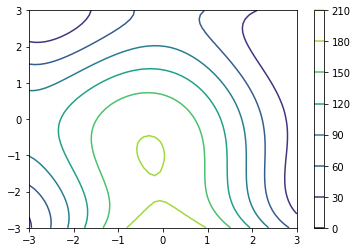

In [1]:
import os
import torch
import gpytorch
import matplotlib.pyplot as plt
from botorch.optim import optimize_acqf
from botorch.models import ModelListGP
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from helper.ECI_class import ExpectedCoverageImprovement_class
from helper.Dirichlet_GP import DirichletGPModel
from gpytorch.likelihoods import DirichletClassificationLikelihood

SMOKE_TEST = os.environ.get("SMOKE_TEST")

def f(x1, x2): return (x1**2+x2-11)**2+(x1+x2**2-7)**2
x1 = np.linspace(-3, 3)
x2 = np.linspace(-3, 3)
X1, X2 = np.meshgrid(x1, x2)

plt.contour(X1, X2, f(X1, X2)+random.random(), cmap = 'viridis')
cbar = plt.colorbar()


In [2]:
tkwargs = {
    # "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
    "dtype": torch.double,
}

In [3]:
def get_and_fit_gp(X, Y):
    # Find optimal model hyperparameters
    likelihood = DirichletClassificationLikelihood(Y[:,0].long(), learn_additional_noise=True)
    model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(50):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        optimizer.step()
    print("Checkpoint: Model trained")
    return model

In [4]:
def yf(x):
    v = (((x[:,0]**2+x[:,1]-11)**2+(x[:,0]+x[:,1]**2-7)**2)>160).float()
    return torch.stack((v, v), dim=-1)

In [5]:
bounds = torch.tensor([[-3, -3], [3, 3]], **tkwargs)
lb, ub = bounds
dim = len(lb)
punchout_radius = 0.6

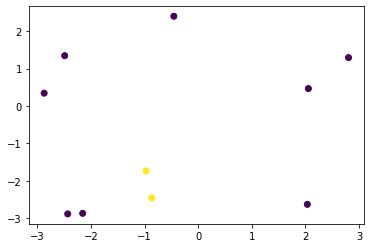

In [6]:
num_init_points = 5
num_total_points = 20 

def get_first_N_points(num):
    with open("./trainx.txt","r") as x:
        data = eval(x.read())
    train_x = torch.tensor(data)[0:num,:]
    with open("./trainy.txt","r") as y:
        data = eval(y.read())
    train_y = torch.tensor(data)[0:num]
    return train_x, train_y


X, Y = get_first_N_points(10)

X = X.double()
Y = Y.unsqueeze(-1).repeat(1,2).double()
# Convert to format usable for ECI
plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=Y[:,0])


In [7]:
while len(X) < num_total_points:
    # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
    # appropriately adjust the punchout radius if the domain is normalized.
    print("Checkpoint: build gp model")
    gp_models = get_and_fit_gp(X.float(), Y[:, 0:1])
    print("Checkpoint: ECI")
    eci = ExpectedCoverageImprovement_class(
        model=gp_models,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=50,
    )

    print("Checkpoint: x_next")
    # Switch to eval mode
    gp_models.eval()

    x_next, _ = optimize_acqf(
            acq_function=eci,
            bounds=bounds,
            q=1,
            num_restarts=10,
            raw_samples=512,
        )
    print(f"Got x_next: {x_next}")
    y_next = yf(x_next)

    X = torch.cat((X, x_next))
    Y = torch.cat((Y, y_next))
    print("Added new point to training data")

Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[ 0.1171, -1.8685]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[-0.0179, -2.9733]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[-0.3659, -0.5031]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[-1.4475, -0.8903]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[ 0.7088, -0.9337]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[0.2894, 0.3074]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[ 1.0686, -2.2277]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[-1.0315, -3.0000]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Got x_next: tensor([[2.4413, 2.9802]], dtype=torch.float64)
Added new point to training data
Checkpoint: build gp model
Checkpoint: Model trained
Checkpoint: ECI
Checkpoint: x_next
Got x_next: tensor([[-0.3261, -1.3162]], dtype=torch.float64)
Added new point to training data


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Leo\AppData\Local\Temp\ipykernel_20256\2339520125.py:33: UserWarning: No contour levels were found within the data range.
  ax.contour(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), [-10, 0], colors="k")


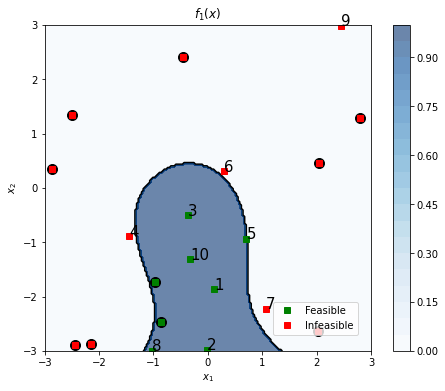

In [8]:
N1, N2 = 200, 200
constraints = [("lt", 1.01), ("gt", 0.95)]
Xplt, Yplt = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
yplt = yf(xplt)
Zplt = torch.reshape(yplt[:, 0], (N1, N2)) 
def identify_samples_which_satisfy_constraints(X, constraints):
    """
    Takes in values (a1, ..., ak, o) and returns (a1, ..., ak, o)
    True/False values, where o is the number of outputs.
    """
    successful = torch.ones(X.shape).to(X)
    for model_index in range(X.shape[-1]):
        these_X = X[..., model_index]
        direction, value = constraints[model_index]
        successful[..., model_index] = (
            these_X < value if direction == "lt" else these_X > value
        )
    return successful


fig, ax = plt.subplots(figsize=(8, 6))
h1 = ax.contourf(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), 20, cmap="Blues", alpha=0.6)
fig.colorbar(h1)
ax.contour(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), [-10, 0], colors="k")

feasible_inds = (
    identify_samples_which_satisfy_constraints(Y, constraints)
    .prod(dim=-1)
    .to(torch.bool)
)
ax.plot(X[feasible_inds, 0].cpu(), X[feasible_inds, 1].cpu(), "sg", label="Feasible")
ax.plot(
    X[~feasible_inds, 0].cpu(), X[~feasible_inds, 1].cpu(), "sr", label="Infeasible"
)
ax.scatter(X.cpu()[:10, 0], X.cpu()[:10, 1], marker = 'o', s=100, color = 'k')
ind = 1
for i in X[10:]:
    plt.text(i[0],i[1],ind, size = 15)
    ind += 1
ax.legend(loc=[0.7, 0.05])
ax.set_title("$f_1(x)$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_aspect("equal", "box")
plt.show()

In [9]:
def for_plotting_only(x1, x2):
    ans = (x1**2+x2-11)**2+(x1+x2**2-7)**2
    return (ans > 160).float()

In [10]:
test_x_mat, test_y_mat = np.meshgrid(np.linspace(-3, 3, N1), np.linspace(-3, 3, N2))
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)
test_labels = for_plotting_only(test_x_mat, test_y_mat)

In [11]:
test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

In [12]:
posterior = gp_models(test_x)

In [13]:
pred_samples = posterior.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

Text(0.5, 1.0, 'Probabilities')

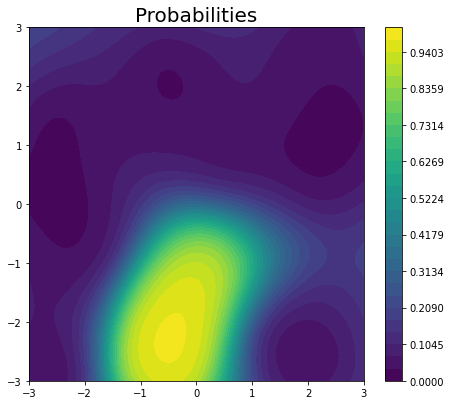

In [14]:
levels = torch.linspace(0, 1.01, 30)
plt.figure(figsize=(7.5, 6.5))
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), probabilities[1].numpy().reshape(N1,N2), levels=levels)
plt.colorbar()
plt.title('Probabilities', fontsize=20)


Text(0.5, 1.0, 'Estimated Boundary')

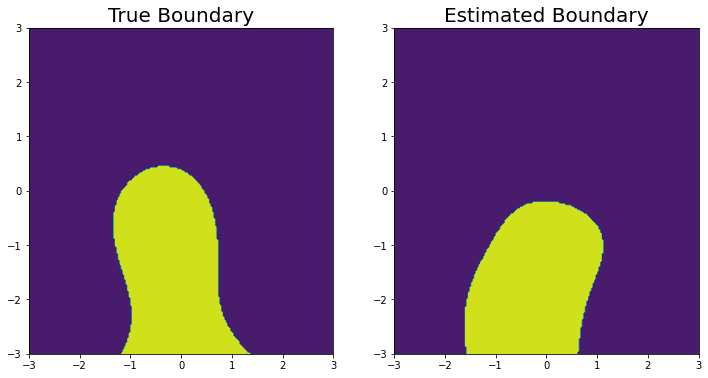

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Boundary', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), posterior.loc.max(0)[1].reshape((N1,N2)))
ax[1].set_title('Estimated Boundary', fontsize=20)

Note:
1. Need to fix the need to switch between float and double
2. We need to do something about the likelihood eval ?
3. Do we need both torch.no_grad and model.eval()?